In [19]:
from deepface import DeepFace
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import numpy as np
import mediapipe as mp
import supervision as sv

## Getting the reference image

In [53]:
face_objs = DeepFace.extract_faces(
    img_path="reference_image.jpg",
    detector_backend="opencv",
    align=False,
    normalize_face=False,
    color_face="bgr",
  )

In [54]:
OUTPUT_SIZE = (200, 200)

def fit_to_output_size(frame: np.ndarray) -> np.ndarray:
    """
    Resize a frame to the output size.
    """
    return cv2.resize(frame, OUTPUT_SIZE)

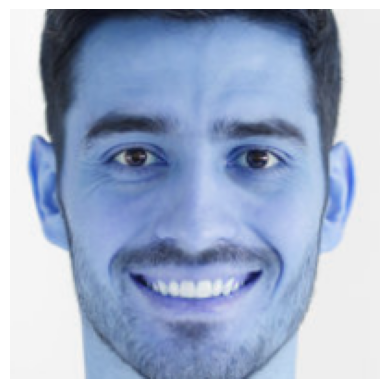

In [55]:
face = face_objs[0]["face"]
frame = fit_to_output_size(face)

plt.imshow(frame)
plt.axis('off')

plt.show()

In [56]:
VERTEX_COLOR = sv.Color.WHITE
VERTEX_RADIUS = 1

model = mp.solutions.face_mesh.FaceMesh()
annotator = sv.VertexAnnotator(color=VERTEX_COLOR, radius=VERTEX_RADIUS)

In [57]:
resolution_wh = (frame.shape[1], frame.shape[0])
processed_frame = model.process(frame)
key_points = sv.KeyPoints.from_mediapipe(processed_frame, resolution_wh)

In [58]:
np.save('key_points_xy.npy', key_points.xy)

In [59]:
loaded_key_points = np.load('key_points_xy.npy')
print(loaded_key_points)

[[[100.8528   141.71785 ]
  [101.27971  127.094696]
  [100.96173  131.76038 ]
  [ 96.02044  102.65891 ]
  [101.38147  119.86497 ]
  [101.328995 109.9443  ]
  [101.06654   85.91554 ]
  [ 56.23008   83.319824]
  [100.99375   69.39019 ]
  [101.06004   60.248775]
  [101.2023    26.716269]
  [100.82153  144.3073  ]
  [100.744125 145.5636  ]
  [100.699425 145.08713 ]
  [100.794365 159.57945 ]
  [100.80895  161.7003  ]
  [100.74192  164.2228  ]
  [100.661674 167.37747 ]
  [100.431206 173.0567  ]
  [101.13381  130.51608 ]
  [ 94.28403  129.03232 ]
  [ 32.58453   58.226498]
  [ 74.94438   89.074394]
  [ 68.633354  89.2867  ]
  [ 62.38482   88.83253 ]
  [ 53.485096  85.46926 ]
  [ 80.04904   87.85061 ]
  [ 65.459755  72.319626]
  [ 72.39288   72.75271 ]
  [ 59.005154  73.638115]
  [ 54.64747   76.15971 ]
  [ 48.47551   89.33156 ]
  [ 76.199394 180.33757 ]
  [ 53.612827  81.892815]
  [ 29.300201  87.00691 ]
  [ 41.295807  85.771095]
  [ 66.571    114.95435 ]
  [ 89.65501  140.42413 ]
  [ 90.10622

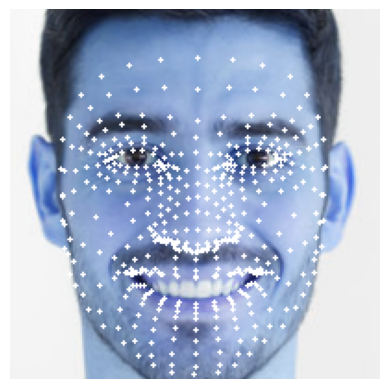

In [60]:
out_frame = annotator.annotate(frame, key_points)

plt.imshow(out_frame)
plt.axis('off')

plt.show()

## Get the face for frontalization

In [123]:
face_objs = DeepFace.extract_faces(
    img_path="test_image2.jpg",
    detector_backend="opencv",
    align=False,
    normalize_face=False,
    color_face="bgr",
  )

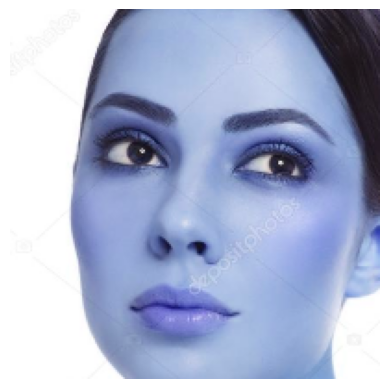

In [124]:
face = face_objs[0]["face"]
frame = fit_to_output_size(face)

plt.imshow(frame)
plt.axis('off')

plt.show()

In [125]:
resolution_wh = (frame.shape[1], frame.shape[0])
processed_frame = model.process(frame)
key_points = sv.KeyPoints.from_mediapipe(processed_frame, resolution_wh)

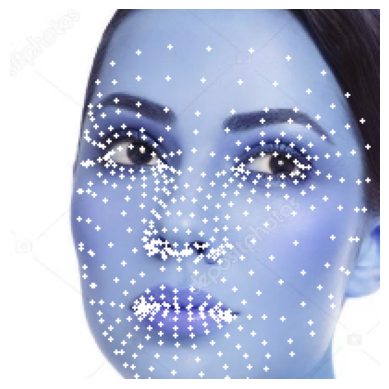

In [126]:
out_frame = annotator.annotate(frame, key_points)

plt.imshow(out_frame)
plt.axis('off')

plt.show()

## Frontalization

In [127]:
face_to_frontalize_keypoints = key_points.xy
reference_keypoints = np.load('key_points_xy.npy')

print("Shape of face_to_frontalize_keypoints:", face_to_frontalize_keypoints.shape)
print("Shape of reference_keypoints:", reference_keypoints.shape)

Shape of face_to_frontalize_keypoints: (1, 468, 2)
Shape of reference_keypoints: (1, 468, 2)


### AffinePartial2D

In [128]:
# Estimate the affine transformation
matrix, inliers = cv2.estimateAffinePartial2D(face_to_frontalize_keypoints[0], reference_keypoints[0])
frontalized_keypoints = cv2.transform(np.array([face_to_frontalize_keypoints[0]]), matrix)[0]

### Procrustes Analysis

In [132]:
def procrustes_analysis(X, Y):
    """
    Perform Procrustes analysis to align X to Y.
    X and Y are expected to have shape (N, 2) where N is the number of keypoints.
    """
    # Subtract the centroid (mean) of the points
    X_mean = np.mean(X, axis=0)
    Y_mean = np.mean(Y, axis=0)
    
    X_centered = X - X_mean
    Y_centered = Y - Y_mean
    
    # Normalize the points (scaling to unit variance)
    X_norm = np.linalg.norm(X_centered)
    Y_norm = np.linalg.norm(Y_centered)
    
    X_centered /= X_norm
    Y_centered /= Y_norm
    
    # Compute the optimal rotation matrix using SVD
    U, _, Vt = np.linalg.svd(np.dot(X_centered.T, Y_centered))
    R = np.dot(U, Vt)
    
    # Apply the rotation matrix to X
    X_aligned = np.dot(X_centered, R)
    
    # Rescale and shift X_aligned back to original scale and position
    X_aligned = X_aligned * Y_norm + Y_mean
    
    return X_aligned

frontalized_keypoints = procrustes_analysis(face_to_frontalize_keypoints[0], reference_keypoints[0])

### Homography-based Frontalization

In [135]:
def homography_frontalization(src_points, dst_points):
    # Calculate the homography matrix
    homography_matrix, _ = cv2.findHomography(src_points, dst_points)

    # Apply the homography transformation to the source points
    src_points_homogeneous = np.concatenate([src_points, np.ones((src_points.shape[0], 1))], axis=1)
    dst_points_homogeneous = np.dot(homography_matrix, src_points_homogeneous.T).T

    # Convert homogeneous coordinates back to 2D
    dst_points_homogeneous /= dst_points_homogeneous[:, 2][:, np.newaxis]
    
    frontalized_points = dst_points_homogeneous[:, :2]  # Extract x, y coordinates
    
    return frontalized_points

frontalized_keypoints = homography_frontalization(face_to_frontalize_keypoints[0], reference_keypoints[0])


## Frontalized visualization

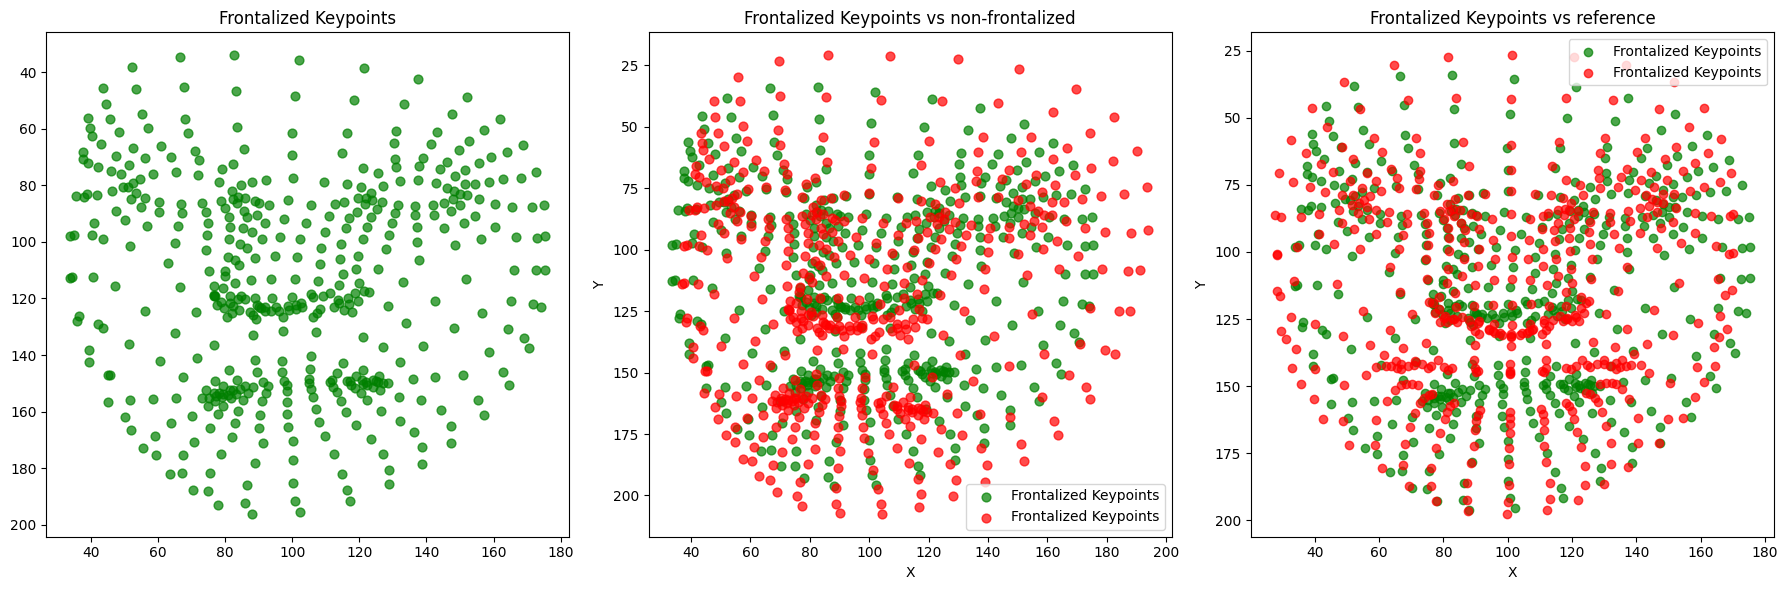

In [148]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))  # Adjust the figure size for better spacing

# Just frontalized
plt.subplot(1, 3, 1)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.title(f'Frontalized Keypoints')
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

# Frontalized vs non-frontalized
plt.subplot(1, 3, 2)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.scatter(face_to_frontalize_keypoints[0][:, 0], face_to_frontalize_keypoints[0][:, 1], 
            color='red', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.title(f'Frontalized Keypoints vs non-frontalized')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

# Frontalized vs Reference
plt.subplot(1, 3, 3)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7)

plt.scatter(reference_keypoints[0][:, 0], reference_keypoints[0][:, 1], 
            color='red', label='Frontalized Keypoints', alpha=0.7)

plt.title(f'Frontalized Keypoints vs reference')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()